In [32]:
import numpy as np
import os
import pandas as pd
import sqlite3
from scipy import stats
import matplotlib.pyplot as plt
import tarfile
import zipfile
from scipy.io import loadmat
from urllib.request import urlretrieve
from os.path import isfile, isdir
import plotly.express as px
from collections import Counter
from scipy.stats import chi2_contingency
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, precision_score, recall_score, accuracy_score, roc_auc_score
from sklearn import metrics
%matplotlib inline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

In [2]:
df_train = pd.read_csv("./data/train.csv")

In [3]:
total_palabras = 0

for fila in df_train.iterrows():
    for columna in df_train.columns:
        celda = str(fila[1][columna])
        palabras = celda.split()
        total_palabras += len(palabras)

print("Total de palabras en el dataset:", total_palabras)

Total de palabras en el dataset: 9020


In [4]:
# Obtener una lista de todos los títulos
titulos = df_train['titulo'].tolist()

# Crear una matriz (DataFrame) con palabras únicas como columnas
palabras_unicas = list(set(' '.join(titulos).split()))
matriz_frecuencia = pd.DataFrame(0, columns=palabras_unicas, index=titulos)

# Bucle para contar la frecuencia de palabras en cada título
for titulo in titulos:
    palabras = titulo.split()
    for palabra in palabras:
        matriz_frecuencia.at[titulo, palabra] += 1

# Imprimir la matriz de frecuencia
print(matriz_frecuencia)

                                                    fusión  debió  Monstruo  \
"De nada sirven los triunfos si la paz no los c...       0      0         0   
"Hay mejores formas para uno mostrar su forma d...       0      0         0   
#LosNacionalesXSeñal - Bahía Cupica                      0      0         0   
#LosNacionalesXSeñal - Estudiantes Utech balonmano       0      0         0   
#LosNacionalesXSeñal - Las pruebas de triatlón ...       0      0         0   
...                                                    ...    ...       ...   
¿Qué harías tú? - Esto se puso salsa                     0      0         0   
¿Qué opinas sobre el machismo?                           0      0         0   
¿Te cortarón los servicios?.. Tranquilo ya esta...       0      0         0   
Óscar Figueroa, con dos medallas en el Mundial ...       0      0         0   
Último día de competencias del Ciclismo de Pist...       0      0         0   

                                                   

In [5]:
todos_titulos = ' '.join(titulos)

# Dividir la cadena en palabras
palabras = todos_titulos.split()

# Contar la frecuencia de cada palabra
contador_palabras = Counter(palabras)

# Obtener las 10 palabras más repetidas
palabras_mas_repetidas = contador_palabras.most_common(10)

# Imprimir las 10 palabras más repetidas
for palabra, frecuencia in palabras_mas_repetidas:
    print(f'Palabra: {palabra}, Frecuencia: {frecuencia}')

Palabra: -, Frecuencia: 950
Palabra: de, Frecuencia: 296
Palabra: que, Frecuencia: 207
Palabra: vemos, Frecuencia: 205
Palabra: lo, Frecuencia: 203
Palabra: Todo, Frecuencia: 200
Palabra: en, Frecuencia: 66
Palabra: Televidente, Frecuencia: 60
Palabra: la, Frecuencia: 58
Palabra: y, Frecuencia: 57


In [6]:
eliminar_palabras = ["-", "de", "que", "vemos", "lo", "todo", "en", "Televidente", "la", "y"]

# Función para eliminar palabras específicas de un título y reemplazar tildes y "ñ"
def procesar_titulo(titulo):
    # Eliminar palabras específicas
    palabras = titulo.split()
    palabras_filtradas = [palabra for palabra in palabras if palabra not in eliminar_palabras]
    
    # Reemplazar tildes y "ñ"
    titulo_modificado = ' '.join(palabras_filtradas)
    titulo_modificado = titulo_modificado.replace('á', 'a').replace('é', 'e').replace('í', 'i').replace('ó', 'o').replace('ú', 'u')
    titulo_modificado = titulo_modificado.replace('Á', 'A').replace('É', 'E').replace('Í', 'I').replace('Ó', 'O').replace('Ú', 'U')
    titulo_modificado = titulo_modificado.replace('ñ', 'n').replace('Ñ', 'N')
    
    return titulo_modificado

# Aplicar la función para procesar el título a la columna 'titulo'
df_train['titulo_procesado'] = df_train['titulo'].apply(procesar_titulo)

# Imprimir el DataFrame resultante
print(df_train['titulo_procesado'])

0      "De nada sirven los triunfos si paz no los cor...
1      "Hay mejores formas para uno mostrar su forma ...
2                      #LosNacionalesXSenal Bahia Cupica
3       #LosNacionalesXSenal Estudiantes Utech balonmano
4      #LosNacionalesXSenal Las pruebas triatlon llen...
                             ...                        
795                   ¿Que harias tu? Esto se puso salsa
796                       ¿Que opinas sobre el machismo?
797    ¿Te cortaron los servicios?.. Tranquilo ya est...
798    Oscar Figueroa, con dos medallas el Mundial Le...
799    Ultimo dia competencias del Ciclismo Pista Jue...
Name: titulo_procesado, Length: 800, dtype: object


In [7]:
contingency_table = pd.crosstab(df_train['titulo_procesado'], df_train['categoria'])

correlaciones = []

# Calcular el coeficiente de correlación de Cramer-V para cada título y categoría
for titulo in df_train['titulo_procesado'].unique():
    if titulo in contingency_table.index:
        observed = contingency_table.loc[titulo].to_numpy().astype(np.float64)  # Asegurarse de que observed sea de tipo float64
        observed += 0.5  # Sumar 0.5
        chi2, _, _, _ = chi2_contingency([observed])
        n = observed.sum()
        phi2 = chi2 / n
        phi2corr = max(0, phi2 - 1 / n)
        cramer_v = np.sqrt(phi2corr)
    
        correlaciones.append((titulo, cramer_v))
for titulo, correlacion in correlaciones:
    print(f"Correlación '{titulo}': {correlacion}")

Correlación '"De nada sirven los triunfos si paz no los corona" #LaPazHabla': 0.0
Correlación '"Hay mejores formas para uno mostrar su forma pensar" Sofia': 0.0
Correlación '#LosNacionalesXSenal Bahia Cupica': 0.0
Correlación '#LosNacionalesXSenal Estudiantes Utech balonmano': 0.0
Correlación '#LosNacionalesXSenal Las pruebas triatlon llenaron emocion al municipio Prado': 0.0
Correlación '#LosNacionalesXSenal Maria Elena Hurtado, Pele antioquena': 0.0
Correlación '#LosNacionalesXSenal Ninos voley playa': 0.0
Correlación '#LosNacionalesXSenal ¡Hicimos historia!': 0.0
Correlación '#PedaleoPor: Ariel Molina envia un saludo a los escarabajos': 0.0
Correlación '#PedaleoPor: Dagoberto Lopez envia un saludo a los escarabajos': 0.0
Correlación '#PedaleoPor: Esteban Kekessy envia un saludo a los escarabajos': 0.0
Correlación '#PedaleoPor: Henry Garcia envia un saludo a los escarabajos': 0.0
Correlación '#PedaleoPor: James Guevara envia un saludo a los escarabajos': 0.0
Correlación '#PedaleoPo

In [8]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

def obtener_matriz_caracteristicas(titulos_procesados):
    vectorizer = CountVectorizer(binary=True)
    matriz_caracteristicas = vectorizer.fit_transform(titulos_procesados)
    matriz_caracteristicas_df = pd.DataFrame(matriz_caracteristicas.toarray(), columns=vectorizer.get_feature_names_out())
    return matriz_caracteristicas_df

# Ejemplo de uso:
titulos_procesados_ejemplo = ["titulo procesado 1", "titulo procesado 2", "titulo procesado 3"]
matriz_caracteristicas_resultado = obtener_matriz_caracteristicas(titulos_procesados_ejemplo)
print(matriz_caracteristicas_resultado)

   procesado  titulo
0          1       1
1          1       1
2          1       1


In [9]:
titulos = df_train['titulo_procesado'].tolist()
matriz_frecuencia = pd.DataFrame(0, columns=palabras_unicas, index=titulos)

for titulo in titulos:
    palabras = titulo.split()
    total_palabras = len(palabras)
    
    for palabra in palabras:
        frecuencia = palabras.count(palabra)
        frecuencia_relativa = frecuencia / total_palabras
        matriz_frecuencia.at[titulo, palabra] = frecuencia_relativa

# Imprimir la matriz de frecuencia relativa
print(matriz_frecuencia)

C:\Users\MELASNIE\AppData\Local\Temp\ipykernel_9796\3979912341.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  matriz_frecuencia.at[titulo, palabra] = frecuencia_relativa
C:\Users\MELASNIE\AppData\Local\Temp\ipykernel_9796\3979912341.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  matriz_frecuencia.at[titulo, palabra] = frecuencia_relativa
C:\Users\MELASNIE\AppData\Local\Temp\ipykernel_9796\3979912341.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many t

                                                    fusión  debió  Monstruo  \
"De nada sirven los triunfos si paz no los coro...       0      0       0.0   
"Hay mejores formas para uno mostrar su forma p...       0      0       0.0   
#LosNacionalesXSenal Bahia Cupica                        0      0       0.0   
#LosNacionalesXSenal Estudiantes Utech balonmano         0      0       0.0   
#LosNacionalesXSenal Las pruebas triatlon llena...       0      0       0.0   
...                                                    ...    ...       ...   
¿Que harias tu? Esto se puso salsa                       0      0       0.0   
¿Que opinas sobre el machismo?                           0      0       0.0   
¿Te cortaron los servicios?.. Tranquilo ya esta...       0      0       0.0   
Oscar Figueroa, con dos medallas el Mundial Lev...       0      0       0.0   
Ultimo dia competencias del Ciclismo Pista Jueg...       0      0       0.0   

                                                   

C:\Users\MELASNIE\AppData\Local\Temp\ipykernel_9796\3979912341.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  matriz_frecuencia.at[titulo, palabra] = frecuencia_relativa
C:\Users\MELASNIE\AppData\Local\Temp\ipykernel_9796\3979912341.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  matriz_frecuencia.at[titulo, palabra] = frecuencia_relativa
C:\Users\MELASNIE\AppData\Local\Temp\ipykernel_9796\3979912341.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many t

In [10]:
def calcular_numero_documentos_con_palabra(data, columna_texto, palabras_unicas):
    num_documentos_con_palabra = []
    for palabra in palabras_unicas:
        num_documentos = sum(data[columna_texto].str.contains(r'\b{}\b'.format(palabra), case=False, regex=False))
        num_documentos_con_palabra.append(num_documentos)
    return num_documentos_con_palabra

# Calcular el IDF para cada palabra
def calcular_idf(total_documentos, num_documentos_con_palabra):
    idf = [np.log(total_documentos / (num + 1)) for num in num_documentos_con_palabra]
    return idf

palabras_unicas = list(set(' '.join(df_train['titulo_procesado']).split()))

# Calcular el número total de documentos (títulos)
total_documentos = len(df_train)

# Calcular el número de documentos que contienen cada palabra
num_documentos_con_palabra = calcular_numero_documentos_con_palabra(df_train, 'titulo', palabras_unicas)

# Calcular el IDF para cada palabra
idf = calcular_idf(total_documentos, num_documentos_con_palabra)

# Crear un DataFrame para mostrar los resultados
idf_df = pd.DataFrame({'Palabra': palabras_unicas, 'IDF': idf})

# Imprimir el DataFrame de IDF
print(idf_df)

        Palabra       IDF
0      Monstruo  6.684612
1       Andres,  6.684612
2            Un  6.684612
3      Santiago  6.684612
4     cincuenta  6.684612
...         ...       ...
2091         Ca  6.684612
2092    Miranda  6.684612
2093    criolla  6.684612
2094      debio  6.684612
2095   'Amrika,  6.684612

[2096 rows x 2 columns]


In [14]:
idf_df = idf_df[:800]
dataframe = pd.DataFrame(idf_df['IDF'])
print(dataframe)

          IDF
0    6.684612
1    6.684612
2    6.684612
3    6.684612
4    6.684612
..        ...
795  6.684612
796  6.684612
797  6.684612
798  6.684612
799  6.684612

[800 rows x 1 columns]


In [12]:
y = df_train['categoria']

In [24]:
x_train, x_test, y_train, y_test = train_test_split(dataframe, y, train_size = 0.8, random_state = 42)

# RF

In [34]:
rf = RandomForestClassifier(n_estimators=100)
rf.fit(x_train, y_train)

RandomForestClassifier(random_state=42)

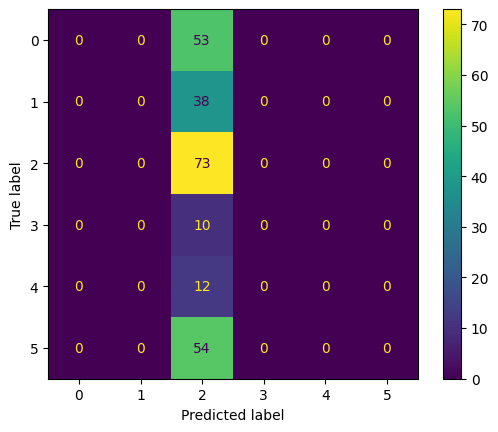

In [41]:
y_predict = rf.predict(x_test)
cm = confusion_matrix(y_test, y_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             )
disp.plot()

In [43]:
results = pd.DataFrame({'ID': test_data['index'], 'categoria': y_pred})

results.to_csv('prediccionesrfs.csv', index=False)

# LSTM

In [16]:
x = dataframe.values
y = df_train['categoria'].values

numero_de_clases = len(np.unique(y))

x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.9, random_state=42)

model = Sequential()
model.add(LSTM(128, input_shape=(x_train.shape[1], 1)))  
model.add(Dense(numero_de_clases, activation='softmax'))  

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [18]:
# Carga los datos de entrenamiento y prueba
train_data = pd.read_csv('./data/train.csv')
test_data = pd.read_csv('./data/test.csv')
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(train_data['titulo'])
y_train = train_data['categoria']

param_grid = {'C': [0.01, 0.1, 1, 10, 100]}
grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=5)
grid_search.fit(X_train_tfidf, y_train)
best_C = grid_search.best_params_['C']

lr = LogisticRegression(C=best_C)
lr.fit(X_train_tfidf, y_train)

X_test_tfidf = tfidf_vectorizer.transform(test_data['titulo'])

y_pred = lr.predict(X_test_tfidf)

results = pd.DataFrame({'ID': test_data['index'], 'categoria': y_pred})

results.to_csv('predicciones_lstm.csv', index=False)

C:\Users\MELASNIE\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\MELASNIE\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.or